# Monte Carlo & Q-learning

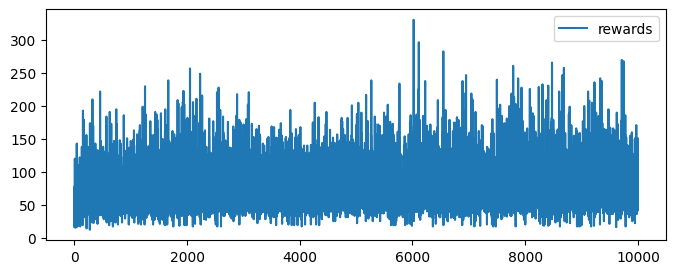

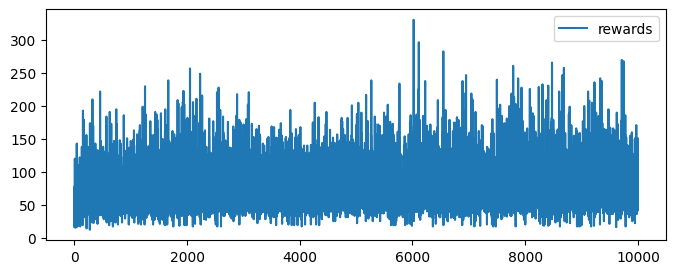

In [5]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from IPython.display import display, clear_output
import random
from collections import defaultdict

import gymnasium as gym

from utils import sample_episode, digitize, get_bins

# monte carlo samples episodes then learns Q table using simple monte carlo estimates.
def monte_carlo(n_episodes=100):
    env = gym.make('CartPole-v1', render_mode="rgb_array")
    n_actions = env.action_space.n

    bin_size=30
    bins = get_bins(bin_size)
    # state-value function Q lookup table: q(state, action).
    Q = np.random.uniform(size=[bin_size]*len(bins) + [n_actions])
    # returns table: returns(state, action)
    R = np.zeros_like(Q)
    # Counters table: number of times state, action pair was visited for the first time
    N = np.zeros_like(Q) 

    # Initialize metrics to monitor learning progress.
    rewards = []
    # Turn on interactive mode
    plt.ion()
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 3))
    # Initialize line object and legend
    [line] = ax.plot([], [], label="rewards")
    ax.legend(loc="upper right")

    for i in tqdm(range(n_episodes)):
        policy_wrapper = lambda obs: policy(epsilon=1/(i+1), Q=Q, bins=bins, observation=obs)
        episode = sample_episode(policy_wrapper, env, render=False)
        # update plot.
        rewards.append(sum(e.reward for e in episode))
        line.set_data(range(len(rewards)), rewards)
        ax.relim()  # Recalculate limits
        ax.autoscale_view(True,True,True)  # Rescale the axis
        clear_output(wait=True)  # Clear the output
        display(fig)  # Re-display the figure

        # visited table keeps track of visited state, action pairs. visited[state, action] = bool
        visited = defaultdict(bool)
        r = 0
        # returns are summed from T to 1. Iterate over the episode in reverse order.
        for e in episode[::-1]:
            # digitize continuous observations into discrete bins.
            p, pv, a, av = digitize(e.observation, bins)
            state = (p, pv, a, av, e.action)
            r += e.reward
            # only update on first visit.
            if visited[state]:
                continue

            visited[state] = True
            R[p, pv, a, av, e.action] += r
            N[p, pv, a, av, e.action] += 1
            Q[p, pv, a, av, e.action] = R[p, pv, a, av, e.action]/N[p, pv, a, av, e.action]
        
    env.close()
    plt.ioff()
    # return state-value function Q.
    return Q

# policy is epsilon-greedy with respect to Q.
def policy(epsilon, Q, bins, observation):
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, Q.shape[-1] - 1)  # right bound is included
    
    p, pv, a, av = digitize(observation, bins)
    return np.argmax(Q[p, pv, a, av, :])

Q = monte_carlo(n_episodes=10000)

In [6]:
# save gif.
env = gym.make("CartPole-v1", render_mode="rgb_array")
_ = sample_episode(
    lambda obs: policy(epsilon=0., Q=Q, bins=get_bins(bin_size=30), observation=obs), 
    env=env,
    render=True
)
env.close()